In [51]:
# Семинар 10: гетероскедастичность

import numpy as np
import pandas as pd # чтение файлов
import matplotlib.pyplot as plt # построение графиков
import seaborn as sns # построение графиков
import statsmodels.api as sm # тесты
import statsmodels
import statsmodels.stats.diagnostic as smd # тест Бройша-Пагана

import statsmodels.formula.api as smf

In [3]:
get_ipython().system('pip install rdatasets') # наборы данных
# !pip install pyreadstat # чтение spss/stata данных
from rdatasets import data
# from pyreadstat import read_sav, set_value_labels

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.1/50.1 MB 3.7 MB/s eta 0:00:00


In [21]:
d = pd.read_excel('Heterosk_5.xls')

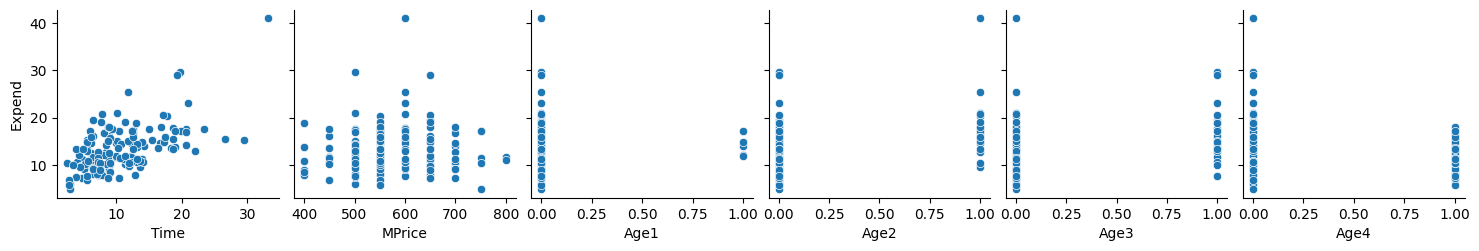

In [22]:
# Построим графики зависимостей затрат от факторов
sns.pairplot(d, x_vars = ["Time", "MPrice", "Age1", "Age2", "Age3", "Age4"], y_vars = ["Expend"])

In [23]:
reg = smf.ols("Expend ~ Time + MPrice + Age1 + Age2 + Age3 + Age4", d).fit()
print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                 Expend   R-squared:                       0.630
Model:                            OLS   Adj. R-squared:                  0.615
Method:                 Least Squares   F-statistic:                     40.37
Date:                Wed, 27 Nov 2024   Prob (F-statistic):           2.15e-28
Time:                        15:25:07   Log-Likelihood:                -370.85
No. Observations:                 149   AIC:                             755.7
Df Residuals:                     142   BIC:                             776.7
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.3682      1.848      1.822      0.0

In [24]:
# Сохраним прогнозные значения
d['expend_pred'] = reg.predict()
# Сохраним остатки модели
d['resid'] = reg.resid
# Cоздадим переменную resid2 = resid^2
d['resid2'] = reg.resid**2
d

,Time,MPrice,Expend,Age1,Age2,Age3,Age4,Age5,expend_pred,resid,resid2
0,6.7,550,9.0,0,0,0,1,0,9.505400,-0.505400,0.255429
1,5.4,600,7.6,0,0,1,0,0,14.185975,-6.585975,43.375073
2,7.2,650,7.8,0,0,0,0,1,9.937136,-2.137136,4.567348
3,14.2,700,14.0,1,0,0,0,0,14.944859,-0.944859,0.892758
4,6.4,650,19.5,0,0,1,0,0,14.915321,4.584679,21.019277
...,...,...,...,...,...,...,...,...,...,...,...
144,7.6,750,10.4,0,0,0,1,0,10.866090,-0.466090,0.217240
145,13.2,600,11.2,0,0,0,1,0,12.996623,-1.796623,3.227855
146,10.5,650,7.3,0,0,0,1,0,11.867979,-4.567979,20.866433
147,7.6,650,9.0,0,0,0,0,1,10.137999,-1.137999,1.295042


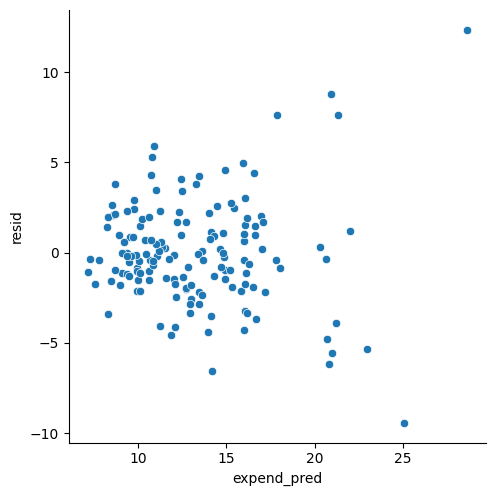

In [41]:
# Построим график зависимости остатков модели от прогнозных значений
sns.pairplot(d, x_vars=['expend_pred'], y_vars=["resid"], height = 5)

In [58]:
X = d[["Time", "MPrice", "Age1", "Age2", "Age3", "Age4"]]
X = sm.add_constant(X) # добавим столбец из 1 в матрицу X, чтобы включить константу

# Тест Уайта
print(smd.het_white(resid = d['resid'], exog = X)[:2])

(93.7411676846798, 1.266689712399042e-12)


In [60]:
# Тест Бройша-Пагана (зависимость дисперсии от конкретных факторов)

BP_test = smd.het_breuschpagan(resid=d['resid'], exog_het=X)
from statsmodels.compat import lzip
print(pd.DataFrame(lzip(['LM statistic', 'p-value',  'F-value', 'F: p-value'], BP_test)[:2]))

# Первое из выданных значений - значение тестовой статистики теста Бройша - Пагана, второе - значение p-value для выданной тестовой
# статистики.
# Третье и четвёртое - значения тестовой статистики и её p-value для на уровне значимости 5% (табличное).
# Вывод: так как p-value=0 < 0.05, то гипотеза H1 не отвергается, то есть етероскедастичность присутствует.

              0             1
0  LM statistic  4.924961e+01
1       p-value  6.645600e-09


In [27]:
abs_reside = abs(d['resid'])
abs_reside

,resid
0,0.505400
1,6.585975
2,2.137136
3,0.944859
4,4.584679
...,...
144,0.466090
145,1.796623
146,4.567979
147,1.137999


In [28]:
# Взвешенный МНК
# Для начала оценим реегрессию модуля остатков на kitsp

reg_w = smf.ols('abs_reside ~ Time', d).fit()
print(reg_w.summary())

# Модель значима, так как p-value=0 в F-тесте

                            OLS Regression Results                            
Dep. Variable:             abs_reside   R-squared:                       0.158
Model:                            OLS   Adj. R-squared:                  0.152
Method:                 Least Squares   F-statistic:                     27.52
Date:                Wed, 27 Nov 2024   Prob (F-statistic):           5.33e-07
Time:                        15:25:22   Log-Likelihood:                -302.12
No. Observations:                 149   AIC:                             608.2
Df Residuals:                     147   BIC:                             614.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.5853      0.329      1.778      0.0

In [29]:
# Зададим веса
reg_w.predict()
weight = reg_w.predict()**2
weight

array([ 2.42189364,  1.87100328,  2.65267642,  6.98624448,  2.28846447,
        5.60648015,  1.87100328,  6.53414781,  1.64068855,  3.35473374,
       10.76366581,  1.64068855,  5.00583281,  3.51588565,  6.60844715,
        3.79287301,  5.60648015,  2.7000931 ,  3.24939934,  5.26858677,
        2.8448634 ,  1.39109994,  2.89396024,  1.9918312 ,  3.24939934,
        1.91085921,  2.99341406,  6.02581358,  2.74792983,  3.09454805,
        4.0803614 , 10.01637595,  5.20226822,  8.01766241,  1.95113518,
        5.53806139,  7.61256237, 11.0508302 ,  5.00583281,  3.51588565,
        2.2016119 ,  3.62542047,  3.30185652,  3.62542047, 29.12381321,
        1.60377291,  5.00583281,  2.15881568,  4.1391192 ,  2.28846447,
       10.5743231 , 15.6968975 ,  3.09454805,  2.37699721,  2.28846447,
        6.83386543,  3.408031  ,  9.03274673,  1.49554624, 12.85320437,
        6.83386543,  1.04047337,  4.43920884,  5.81425668,  1.04047337,
        5.402484  , 23.62388531,  5.20226822,  1.29043401,  3.73

In [30]:
# Оценим с помощью GLS (Feasible GLS) исходную модель регрессии
reg_wls = sm.WLS(d["Expend"], X, weights = weight).fit()
print(reg_wls.summary())

                            WLS Regression Results                            
Dep. Variable:                 Expend   R-squared:                       0.631
Model:                            WLS   Adj. R-squared:                  0.615
Method:                 Least Squares   F-statistic:                     40.46
Date:                Wed, 27 Nov 2024   Prob (F-statistic):           1.96e-28
Time:                        15:25:29   Log-Likelihood:                -439.83
No. Observations:                 149   AIC:                             893.7
Df Residuals:                     142   BIC:                             914.7
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9965      2.683      0.371      0.7

In [32]:
# Второй способ корректировки гетероскедастичности - использование робастных оценок, например, в форме Уайта.

reg_robust = reg.get_robustcov_results(cov_type = 'HC3')
print(reg_robust.summary())

                            OLS Regression Results                            
Dep. Variable:                 Expend   R-squared:                       0.630
Model:                            OLS   Adj. R-squared:                  0.615
Method:                 Least Squares   F-statistic:                     13.23
Date:                Wed, 27 Nov 2024   Prob (F-statistic):           7.21e-12
Time:                        15:27:54   Log-Likelihood:                -370.85
No. Observations:                 149   AIC:                             755.7
Df Residuals:                     142   BIC:                             776.7
Df Model:                           6                                         
Covariance Type:                  HC3                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.3682      2.044      1.647      0.1